# Sentiment Analysis Preprocessing Pipeline

Pada tahap ini dilakukan beberapa langkah preprocessing untuk mempersiapkan dataset sebelum digunakan dalam analisis sentimen.

In [ ]:
# !pip install nltk==3.8.1

import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# NLTK: tokenizer, stopwords, stemmer, lemmatizer, POS tag
import nltk
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Unduh resource NLTK sekali saja (akan di-skip jika sudah ada)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

pd.set_option('display.max_colwidth', 200)

import spacy

# Load spaCy English model
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
# disable parser & ner agar lebih cepat, hanya untuk lemmatization


# Jalankan sekali di Colab/Notebook
# !pip install spacy
# !python -m spacy download en_core_web_sm



In [ ]:
df = pd.read_csv(f'https://drive.google.com/uc?id=1wEF42poKInpWuSLGZ5nY1_CS14n4R9dw')
df

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire p...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue i...",positive
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenl...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what mone...",positive
...,...,...
49995,"I thought this movie did a down right good job. It wasn't as creative or original as the first, but who was expecting it to be. It was a whole lotta fun. the more i think about it the more i like ...",positive
49996,"Bad plot, bad dialogue, bad acting, idiotic directing, the annoying porn groove soundtrack that ran continually over the overacted script, and a crappy copy of the VHS cannot be redeemed by consum...",negative
49997,"I am a Catholic taught in parochial elementary schools by nuns, taught by Jesuit priests in high school & college. I am still a practicing Catholic but would not be considered a ""good Catholic"" in...",negative
49998,"I'm going to have to disagree with the previous comment and side with Maltin on this one. This is a second rate, excessively vicious Western that creaks and groans trying to put across its central...",negative


# EDA

In [ ]:
# 1.2 Cek struktur data
print(df.info())
display(df.head())

# 1.3 Periksa nilai unik pada label
print("Unique sentiments:", df['sentiment'].unique())

# 1.4 Cek nilai kosong
print(df.isna().sum())

# 1.5 Buat kolom metrik sederhana untuk EDA
df['review_len_char'] = df['review'].astype(str).str.len()
df['review_len_token_rough'] = df['review'].astype(str).apply(lambda x: len(x.split()))

# 1.6 Ringkasan statistik panjang review
display(df[['review_len_char', 'review_len_token_rough']].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire p...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue i...",positive
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenl...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what mone...",positive


Unique sentiments: ['positive' 'negative']
review       0
sentiment    0
dtype: int64


,review_len_char,review_len_token_rough
count,50000.000000,50000.000000
mean,1309.431020,231.156940
std,989.728014,171.343997
min,32.000000,4.000000
25%,699.000000,126.000000
50%,970.000000,173.000000
75%,1590.250000,280.000000
max,13704.000000,2470.000000


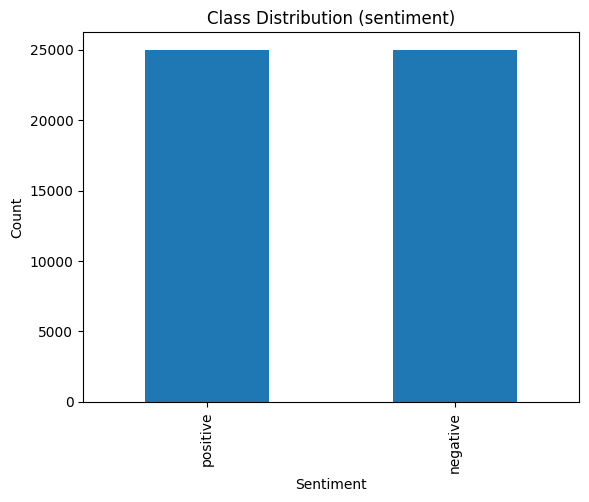

In [ ]:
# 1.7 Plot distribusi kelas (bar plot)
counts = df['sentiment'].value_counts()
plt.figure()
counts.plot(kind='bar', title='Class Distribution (sentiment)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

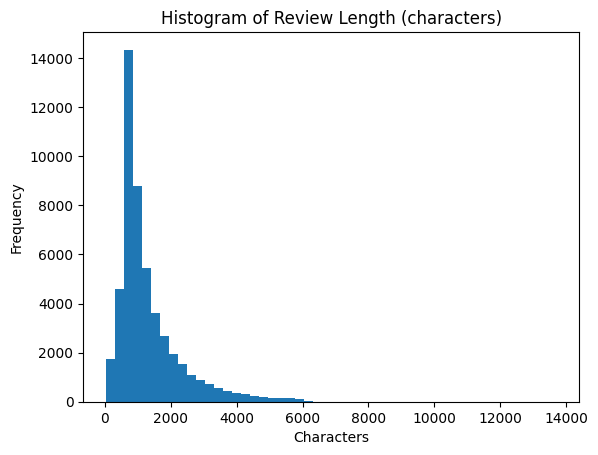

In [ ]:
# 1.8 Histogram panjang review (berdasarkan karakter)
plt.figure()
df['review_len_char'].plot(kind='hist', bins=50, title='Histogram of Review Length (characters)')
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.show()

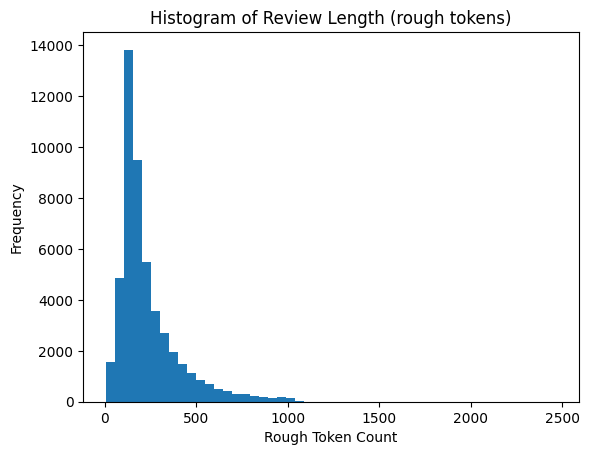

In [ ]:
# 1.9 Histogram panjang review (berdasarkan token "kasar")
plt.figure()
df['review_len_token_rough'].plot(kind='hist', bins=50, title='Histogram of Review Length (rough tokens)')
plt.xlabel('Rough Token Count')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# 1.10 20 kata paling sering (super cepat & kasar, tanpa cleaning detail—hanya indikasi awal)
def top_k_words(texts, k=20):
    counter = Counter(" ".join(texts.astype(str)).lower().split())
    return pd.DataFrame(counter.most_common(k), columns=['token', 'count'])

display(top_k_words(df['review'], k=20))

,token,count
0,the,638861
1,a,316615
2,and,313637
3,of,286661
4,to,264573
5,is,204876
6,in,179807
7,i,141587
8,this,138483
9,that,130140


## 1. Data Cleaning (Stopword)
- Menghilangkan karakter yang tidak diperlukan (angka, tanda baca, simbol, dll).
- Menurunkan huruf menjadi lowercase agar konsisten.
- Hasil disimpan pada kolom **`clean_text`**.

In [ ]:
# Fungsi cleaning yang umum untuk data English
URL_PATTERN = r'https?://\S+|www\.\S+'
HTML_PATTERN = r'<.*?>'
MENTION_PATTERN = r'@\w+'
HASHTAG_PATTERN = r'#\w+'

# Buat set stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text: str) -> str:
    if not isinstance(text, str):
        text = str(text)

    # Basic normalize
    text = text.lower()

    # Remove URLs, HTML, mentions, hashtags
    text = re.sub(URL_PATTERN, ' ', text)
    text = re.sub(HTML_PATTERN, ' ', text)
    text = re.sub(MENTION_PATTERN, ' ', text)
    text = re.sub(HASHTAG_PATTERN, ' ', text)

    # Remove digits dan tanda baca
    text = re.sub(r'\d+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Terapkan cleaning (tidak memodifikasi original)
df['clean_text'] = df['review'].astype(str).apply(clean_text)
display(df[['review', 'clean_text']].head())

,review,clean_text
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me...",one of the other reviewers has mentioned that after watching just oz episode youll be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its...
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire p...",a wonderful little production the filming technique is very unassuming very oldtimebbc fashion and gives a comforting and sometimes discomforting sense of realism to the entire piece the actors ar...
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue i...",i thought this was a wonderful way to spend time on a too hot summer weekend sitting in the air conditioned theater and watching a lighthearted comedy the plot is simplistic but the dialogue is wi...
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenl...,basically theres a family where a little boy jake thinks theres a zombie in his closet his parents are fighting all the time this movie is slower than a soap opera and suddenly jake decides to bec...
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what mone...",petter matteis love in the time of money is a visually stunning film to watch mr mattei offers us a vivid portrait about human relations this is a movie that seems to be telling us what money powe...


## 2. Tokenization
- Memecah kalimat menjadi potongan kata (token).
- Hasil tokenisasi disimpan di kolom **`tokens`**.
- Versi tanpa stopwords (kata umum yang tidak bermakna, seperti *dan, yang, di*) disimpan di kolom **`tokens_nostop`**.

,clean_text,tokens,tokens_nostop
0,one of the other reviewers has mentioned that after watching just oz episode youll be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its...,"[one, of, the, other, reviewers, has, mentioned, that, after, watching, just, oz, episode, youll, be, hooked, they, are, right, as, this, is, exactly, what, happened, with, me, the, first, thing, ...","[one, reviewers, mentioned, watching, oz, episode, youll, hooked, right, exactly, happened, first, thing, struck, oz, brutality, unflinching, scenes, violence, set, right, word, go, trust, show, f..."
1,a wonderful little production the filming technique is very unassuming very oldtimebbc fashion and gives a comforting and sometimes discomforting sense of realism to the entire piece the actors ar...,"[a, wonderful, little, production, the, filming, technique, is, very, unassuming, very, oldtimebbc, fashion, and, gives, a, comforting, and, sometimes, discomforting, sense, of, realism, to, the, ...","[wonderful, little, production, filming, technique, unassuming, oldtimebbc, fashion, gives, comforting, sometimes, discomforting, sense, realism, entire, piece, actors, extremely, well, chosen, mi..."
2,i thought this was a wonderful way to spend time on a too hot summer weekend sitting in the air conditioned theater and watching a lighthearted comedy the plot is simplistic but the dialogue is wi...,"[i, thought, this, was, a, wonderful, way, to, spend, time, on, a, too, hot, summer, weekend, sitting, in, the, air, conditioned, theater, and, watching, a, lighthearted, comedy, the, plot, is, si...","[thought, wonderful, way, spend, time, hot, summer, weekend, sitting, air, conditioned, theater, watching, lighthearted, comedy, plot, simplistic, dialogue, witty, characters, likable, even, well,..."
3,basically theres a family where a little boy jake thinks theres a zombie in his closet his parents are fighting all the time this movie is slower than a soap opera and suddenly jake decides to bec...,"[basically, theres, a, family, where, a, little, boy, jake, thinks, theres, a, zombie, in, his, closet, his, parents, are, fighting, all, the, time, this, movie, is, slower, than, a, soap, opera, ...","[basically, theres, family, little, boy, jake, thinks, theres, zombie, closet, parents, fighting, time, movie, slower, soap, opera, suddenly, jake, decides, become, rambo, kill, zombie, ok, first,..."
4,petter matteis love in the time of money is a visually stunning film to watch mr mattei offers us a vivid portrait about human relations this is a movie that seems to be telling us what money powe...,"[petter, matteis, love, in, the, time, of, money, is, a, visually, stunning, film, to, watch, mr, mattei, offers, us, a, vivid, portrait, about, human, relations, this, is, a, movie, that, seems, ...","[petter, matteis, love, time, money, visually, stunning, film, watch, mr, mattei, offers, us, vivid, portrait, human, relations, movie, seems, telling, us, money, power, success, people, different..."


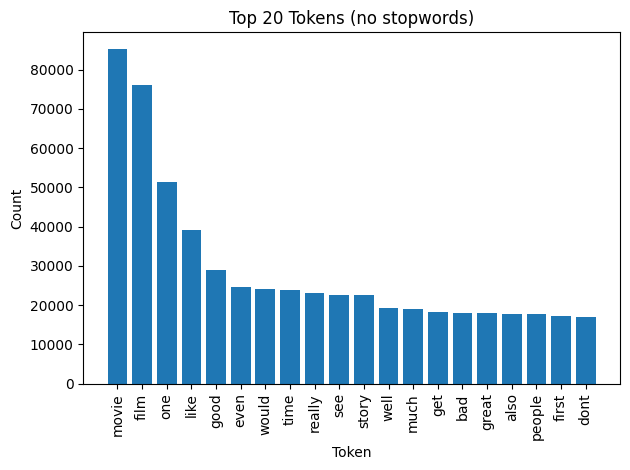

In [ ]:
# 2.1 Tokenize dengan NLTK
def tokenize(text: str):
    # word_tokenize mempertimbangkan tanda baca; karena clean_text sudah menghapus punctuation, hasil lebih "bersih"
    return word_tokenize(text)

# Download punkt_tab resource
nltk.download('punkt_tab', quiet=True)

df['tokens'] = df['clean_text'].apply(tokenize)

# 2.2 (Opsional) Buang stopwords & token sangat pendek
def remove_stop_and_short(tokens, min_len=2):
    return [t for t in tokens if (t not in stop_words) and (len(t) >= min_len)]

df['tokens_nostop'] = df['tokens'].apply(remove_stop_and_short)

# 2.3 Cek beberapa baris
display(df[['clean_text', 'tokens', 'tokens_nostop']].head())

# 2.4 Plot top 20 token setelah stopword removal (EDA lanjutan)
all_tokens = [tok for row in df['tokens_nostop'] for tok in row]
cnt = Counter(all_tokens).most_common(20)
top_df = pd.DataFrame(cnt, columns=['token', 'count'])

plt.figure()
plt.bar(top_df['token'], top_df['count'])
plt.xticks(rotation=90)
plt.title('Top 20 Tokens (no stopwords)')
plt.xlabel('Token')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 3. Stemming
- Mengubah kata ke bentuk dasarnya dengan cara *pemotongan* imbuhan (contoh: *berlari → lari*, *makanan → makan*).
- Tahap ini menggunakan **Sastrawi Stemmer** untuk Bahasa Indonesia.
- Hasil:
  - **`stemmed_tokens`** → list kata hasil stemming.
  - **`stemmed_text`** → teks hasil penggabungan token stemming.

In [ ]:
from nltk.stem import PorterStemmer

# Inisialisasi stemmer
stemmer = PorterStemmer()

def nltk_stemming_from_tokens(tokens_list):
    """
    tokens_list: list/Series of token lists (sudah bebas stopwords)
    return: list of list (stemmed tokens)
    """
    stemmed_docs = []
    for tokens in tokens_list:
        stems = [stemmer.stem(tok.lower()) for tok in tokens if tok.isalpha()]
        stemmed_docs.append(stems)
    return stemmed_docs

# Terapkan stemming dari kolom tokens_nostop
df['stemmed_tokens'] = nltk_stemming_from_tokens(df['tokens_nostop'])
df['stemmed_text'] = df['stemmed_tokens'].apply(lambda toks: " ".join(toks))

# Preview hasil stemming
print("Contoh hasil stemming dari tokens_nostop:")
display(df[['tokens_nostop', 'stemmed_tokens', 'stemmed_text']].head())

Contoh hasil stemming dari tokens_nostop:


,tokens_nostop,stemmed_tokens,stemmed_text
0,"[one, reviewers, mentioned, watching, oz, episode, youll, hooked, right, exactly, happened, first, thing, struck, oz, brutality, unflinching, scenes, violence, set, right, word, go, trust, show, f...","[one, review, mention, watch, oz, episod, youll, hook, right, exactli, happen, first, thing, struck, oz, brutal, unflinch, scene, violenc, set, right, word, go, trust, show, faint, heart, timid, s...",one review mention watch oz episod youll hook right exactli happen first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug se...
1,"[wonderful, little, production, filming, technique, unassuming, oldtimebbc, fashion, gives, comforting, sometimes, discomforting, sense, realism, entire, piece, actors, extremely, well, chosen, mi...","[wonder, littl, product, film, techniqu, unassum, oldtimebbc, fashion, give, comfort, sometim, discomfort, sens, realism, entir, piec, actor, extrem, well, chosen, michael, sheen, got, polari, voi...",wonder littl product film techniqu unassum oldtimebbc fashion give comfort sometim discomfort sens realism entir piec actor extrem well chosen michael sheen got polari voic pat truli see seamless ...
2,"[thought, wonderful, way, spend, time, hot, summer, weekend, sitting, air, conditioned, theater, watching, lighthearted, comedy, plot, simplistic, dialogue, witty, characters, likable, even, well,...","[thought, wonder, way, spend, time, hot, summer, weekend, sit, air, condit, theater, watch, lightheart, comedi, plot, simplist, dialogu, witti, charact, likabl, even, well, bread, suspect, serial,...",thought wonder way spend time hot summer weekend sit air condit theater watch lightheart comedi plot simplist dialogu witti charact likabl even well bread suspect serial killer may disappoint real...
3,"[basically, theres, family, little, boy, jake, thinks, theres, zombie, closet, parents, fighting, time, movie, slower, soap, opera, suddenly, jake, decides, become, rambo, kill, zombie, ok, first,...","[basic, there, famili, littl, boy, jake, think, there, zombi, closet, parent, fight, time, movi, slower, soap, opera, suddenli, jake, decid, becom, rambo, kill, zombi, ok, first, your, go, make, f...",basic there famili littl boy jake think there zombi closet parent fight time movi slower soap opera suddenli jake decid becom rambo kill zombi ok first your go make film must decid thriller drama ...
4,"[petter, matteis, love, time, money, visually, stunning, film, watch, mr, mattei, offers, us, vivid, portrait, human, relations, movie, seems, telling, us, money, power, success, people, different...","[petter, mattei, love, time, money, visual, stun, film, watch, mr, mattei, offer, us, vivid, portrait, human, relat, movi, seem, tell, us, money, power, success, peopl, differ, situat, encount, va...",petter mattei love time money visual stun film watch mr mattei offer us vivid portrait human relat movi seem tell us money power success peopl differ situat encount variat arthur schnitzler play t...


## 4. Lemmatization
- Mengubah kata ke bentuk lema (bentuk dasar secara linguistik, lebih halus daripada stemming).
- Tahap ini dilakukan menggunakan **spaCy**.
- Lemmatization diterapkan langsung pada hasil tokenisasi (`tokens_nostop`) tanpa tokenisasi ulang.
- Hasil:
  - **`lemmatized_tokens`** → list kata hasil lemmatization.
  - **`lemmatized_text`** → teks hasil penggabungan kata lemmatization.

In [ ]:
def spacy_lemmatize_from_tokens(tokens_list):
    """
    tokens_list: list of token lists (sudah bebas stopwords)
    return: list of list (lemmatized tokens)
    """
    lemmatized_docs = []
    for tokens in tokens_list:
        # Buat kembali doc dari tokens
        doc = nlp(" ".join(tokens))
        lemmas = [token.lemma_ for token in doc if token.is_alpha]
        lemmatized_docs.append(lemmas)
    return lemmatized_docs

# Terapkan lemmatization dari kolom tokens_nostop
df['lemmatized_tokens'] = spacy_lemmatize_from_tokens(df['tokens_nostop'])
df['lemmatized_text'] = df['lemmatized_tokens'].apply(lambda toks: " ".join(toks))

# Preview hasil
print("Contoh hasil lemmatization dari tokens_nostop:")
display(df[['tokens_nostop', 'lemmatized_tokens', 'lemmatized_text']].head())

Contoh hasil lemmatization dari tokens_nostop:


,tokens_nostop,lemmatized_tokens,lemmatized_text
0,"[one, reviewers, mentioned, watching, oz, episode, youll, hooked, right, exactly, happened, first, thing, struck, oz, brutality, unflinching, scenes, violence, set, right, word, go, trust, show, f...","[one, reviewer, mention, watch, oz, episode, you, ll, hook, right, exactly, happen, first, thing, strike, oz, brutality, unflinche, scene, violence, set, right, word, go, trust, show, faint, heart...",one reviewer mention watch oz episode you ll hook right exactly happen first thing strike oz brutality unflinche scene violence set right word go trust show faint hearted timid show pull punch reg...
1,"[wonderful, little, production, filming, technique, unassuming, oldtimebbc, fashion, gives, comforting, sometimes, discomforting, sense, realism, entire, piece, actors, extremely, well, chosen, mi...","[wonderful, little, production, filming, technique, unassume, oldtimebbc, fashion, give, comfort, sometimes, discomforte, sense, realism, entire, piece, actor, extremely, well, choose, michael, sh...",wonderful little production filming technique unassume oldtimebbc fashion give comfort sometimes discomforte sense realism entire piece actor extremely well choose michael sheen get polari voice p...
2,"[thought, wonderful, way, spend, time, hot, summer, weekend, sitting, air, conditioned, theater, watching, lighthearted, comedy, plot, simplistic, dialogue, witty, characters, likable, even, well,...","[think, wonderful, way, spend, time, hot, summer, weekend, sit, air, condition, theater, watch, lighthearted, comedy, plot, simplistic, dialogue, witty, character, likable, even, well, bread, susp...",think wonderful way spend time hot summer weekend sit air condition theater watch lighthearted comedy plot simplistic dialogue witty character likable even well bread suspect serial killer may dis...
3,"[basically, theres, family, little, boy, jake, thinks, theres, zombie, closet, parents, fighting, time, movie, slower, soap, opera, suddenly, jake, decides, become, rambo, kill, zombie, ok, first,...","[basically, there, s, family, little, boy, jake, think, there, s, zombie, closet, parent, fight, time, movie, slow, soap, opera, suddenly, jake, decide, become, rambo, kill, zombie, ok, first, you...",basically there s family little boy jake think there s zombie closet parent fight time movie slow soap opera suddenly jake decide become rambo kill zombie ok first you re go make film must decide ...
4,"[petter, matteis, love, time, money, visually, stunning, film, watch, mr, mattei, offers, us, vivid, portrait, human, relations, movie, seems, telling, us, money, power, success, people, different...","[petter, matteis, love, time, money, visually, stunning, film, watch, mr, mattei, offer, we, vivid, portrait, human, relation, movie, seem, tell, we, money, power, success, people, different, situ...",petter matteis love time money visually stunning film watch mr mattei offer we vivid portrait human relation movie seem tell we money power success people different situation encounter variation a...


In [ ]:
# =========================
# Preview hasil preprocessing
# =========================
sample_df = df.head(3)

for idx, row in sample_df.iterrows():
    print(f"Original : {row.get('clean_text', '[missing]')}")
    print(f"Stemmed  : {row.get('stemmed_text', '[not available]')}")
    print(f"Lemmas   : {row.get('lemmatized_text', '[not available]')}")
    print("-" * 80)

Original : one of the other reviewers has mentioned that after watching just oz episode youll be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare forget pr

In [ ]:
# =========================
# Simpan hasil preprocessing
# =========================
out_cols = [
    'review', 'clean_text',
    'tokens', 'tokens_nostop',
    'stemmed_tokens', 'stemmed_text',
    'lemmatized_tokens', 'lemmatized_text',
    'sentiment'
]

available_cols = [c for c in out_cols if c in df.columns]
missing_cols = [c for c in out_cols if c not in df.columns]

if missing_cols:
    print(f"⚠️ Warning: Kolom berikut tidak tersedia dan akan dilewati: {missing_cols}")

df[available_cols].to_csv("preprocessed_sentiment_dataset.csv", index=False)
print(f"✅ Saved to preprocessed_sentiment_dataset.csv with {len(available_cols)} columns")

✅ Saved to preprocessed_sentiment_dataset.csv with 9 columns


## 5. Penyimpanan Hasil
- Semua kolom hasil preprocessing (`tokens`, `tokens_nostop`, `stemmed_tokens`, `lemmatized_tokens`, dll) digabung ke dalam satu DataFrame.
- Dataset disimpan ke file **`preprocessed_sentiment_dataset.csv`** agar bisa digunakan kembali tanpa harus menjalankan preprocessing ulang.

In [ ]:
final_df = pd.read_csv('/content/preprocessed_sentiment_dataset.csv')
final_df.head()

,review,clean_text,tokens,tokens_nostop,stemmed_tokens,stemmed_text,lemmatized_tokens,lemmatized_text,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me...",one of the other reviewers has mentioned that after watching just oz episode youll be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its...,"['one', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching', 'just', 'oz', 'episode', 'youll', 'be', 'hooked', 'they', 'are', 'right', 'as', 'this', 'is', 'exactly',...","['one', 'reviewers', 'mentioned', 'watching', 'oz', 'episode', 'youll', 'hooked', 'right', 'exactly', 'happened', 'first', 'thing', 'struck', 'oz', 'brutality', 'unflinching', 'scenes', 'violence'...","['one', 'review', 'mention', 'watch', 'oz', 'episod', 'youll', 'hook', 'right', 'exactli', 'happen', 'first', 'thing', 'struck', 'oz', 'brutal', 'unflinch', 'scene', 'violenc', 'set', 'right', 'wo...",one review mention watch oz episod youll hook right exactli happen first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug se...,"['one', 'reviewer', 'mention', 'watch', 'oz', 'episode', 'you', 'll', 'hook', 'right', 'exactly', 'happen', 'first', 'thing', 'strike', 'oz', 'brutality', 'unflinche', 'scene', 'violence', 'set', ...",one reviewer mention watch oz episode you ll hook right exactly happen first thing strike oz brutality unflinche scene violence set right word go trust show faint hearted timid show pull punch reg...,positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire p...",a wonderful little production the filming technique is very unassuming very oldtimebbc fashion and gives a comforting and sometimes discomforting sense of realism to the entire piece the actors ar...,"['a', 'wonderful', 'little', 'production', 'the', 'filming', 'technique', 'is', 'very', 'unassuming', 'very', 'oldtimebbc', 'fashion', 'and', 'gives', 'a', 'comforting', 'and', 'sometimes', 'disco...","['wonderful', 'little', 'production', 'filming', 'technique', 'unassuming', 'oldtimebbc', 'fashion', 'gives', 'comforting', 'sometimes', 'discomforting', 'sense', 'realism', 'entire', 'piece', 'ac...","['wonder', 'littl', 'product', 'film', 'techniqu', 'unassum', 'oldtimebbc', 'fashion', 'give', 'comfort', 'sometim', 'discomfort', 'sens', 'realism', 'entir', 'piec', 'actor', 'extrem', 'well', 'c...",wonder littl product film techniqu unassum oldtimebbc fashion give comfort sometim discomfort sens realism entir piec actor extrem well chosen michael sheen got polari voic pat truli see seamless ...,"['wonderful', 'little', 'production', 'filming', 'technique', 'unassume', 'oldtimebbc', 'fashion', 'give', 'comfort', 'sometimes', 'discomforte', 'sense', 'realism', 'entire', 'piece', 'actor', 'e...",wonderful little production filming technique unassume oldtimebbc fashion give comfort sometimes discomforte sense realism entire piece actor extremely well choose michael sheen get polari voice p...,positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue i...",i thought this was a wonderful way to spend time on a too hot summer weekend sitting in the air conditioned theater and watching a lighthearted comedy the plot is simplistic but the dialogue is wi...,"['i', 'thought', 'this', 'was', 'a', 'wonderful', 'way', 'to', 'spend', 'time', 'on', 'a', 'too', 'hot', 'summer', 'weekend', 'sitting', 'in', 'the', 'air', 'conditioned', 'theater', 'and', 'watch...","['thought', 'wonderful', 'way', 'spend'

## 6. Analisis Frekuensi Kata
- Menghitung kata yang paling sering muncul pada hasil preprocessing.
- Dibuat visualisasi **bar chart** untuk kata-kata terbanyak dari:
  - Tokenization
  - Stemming
  - Lemmatization

Top 20 kata paling sering:
movie : 100945
film : 93426
not : 67430
one : 53786
see : 46874
make : 43849
like : 43081
do : 40610
good : 38785
get : 35408
well : 33314
time : 30040
character : 27966
watch : 27485
go : 27317
would : 26502
s : 25196
bad : 25117
story : 24720
even : 24589


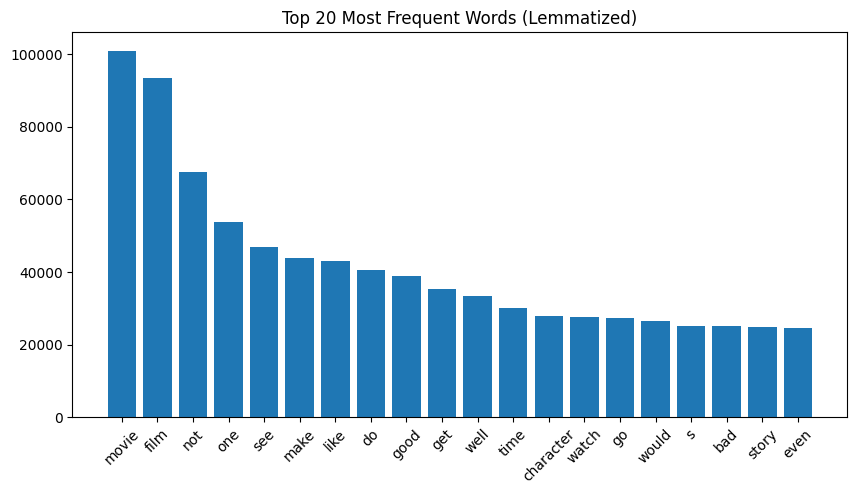

In [ ]:
# =========================
# Load kembali hasil untuk analisis
# =========================
final_df = pd.read_csv("preprocessed_sentiment_dataset.csv")

# Pastikan kolom lemmatized_tokens ada
if 'lemmatized_tokens' in final_df.columns:
    # Jika tersimpan dalam bentuk string list, parse ulang ke list
    from ast import literal_eval
    final_df['lemmatized_tokens'] = final_df['lemmatized_tokens'].apply(
        lambda x: literal_eval(x) if isinstance(x, str) and x.startswith("[") else x
    )

    # Flatten semua token jadi satu list
    all_tokens = [tok for tokens in final_df['lemmatized_tokens'] for tok in (tokens if isinstance(tokens, list) else [])]

    # Ambil 20 kata paling sering
    from collections import Counter
    counter = Counter(all_tokens)
    top_words = counter.most_common(20)

    # Tampilkan
    print("Top 20 kata paling sering:")
    for word, freq in top_words:
        print(f"{word} : {freq}")

    # Visualisasi
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,5))
    plt.bar([w for w, _ in top_words], [f for _, f in top_words])
    plt.xticks(rotation=45)
    plt.title("Top 20 Most Frequent Words (Lemmatized)")
    plt.show()
else:
    print("⚠️ Kolom 'lemmatized_tokens' tidak tersedia untuk analisis frekuensi kata.")

## 7. Analisis Berdasarkan Sentimen (Tambahan)
- Kata dibagi berdasarkan label sentimen (**positive** dan **negative**).
- Kata yang sama tidak boleh muncul di dua kategori (unik per kelas).
- Diambil **Top 10 kata positif** dan **Top 10 kata negatif** untuk masing-masing tahap:
  - Tokenization
  - Stemming
  - Lemmatization
- Visualisasi dibuat dengan **bar chart** untuk perbandingan kata positif (hijau) dan negatif (merah).

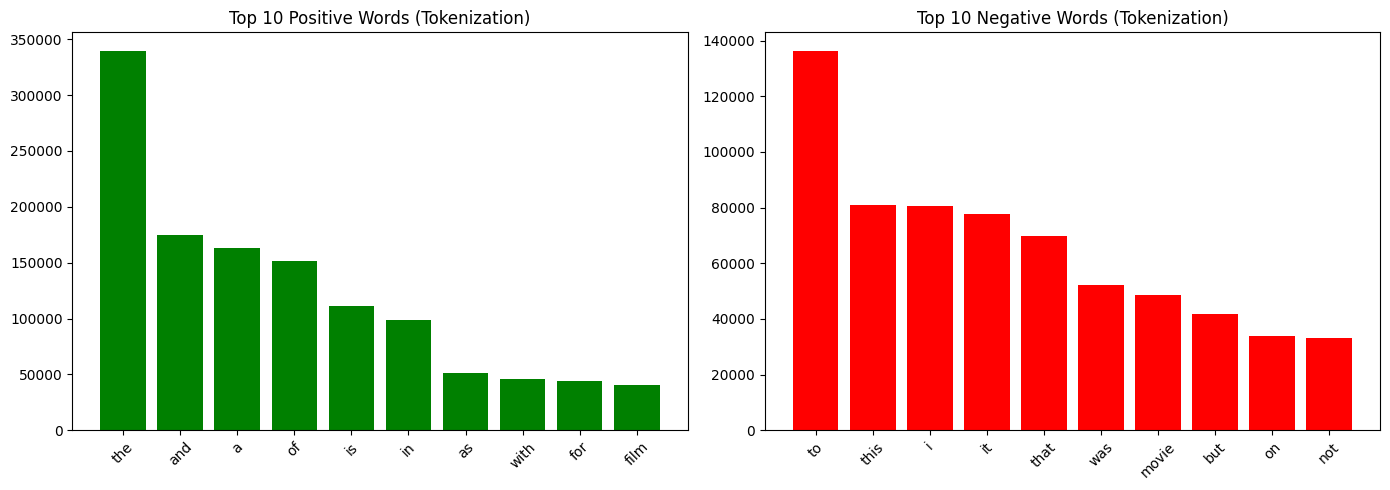

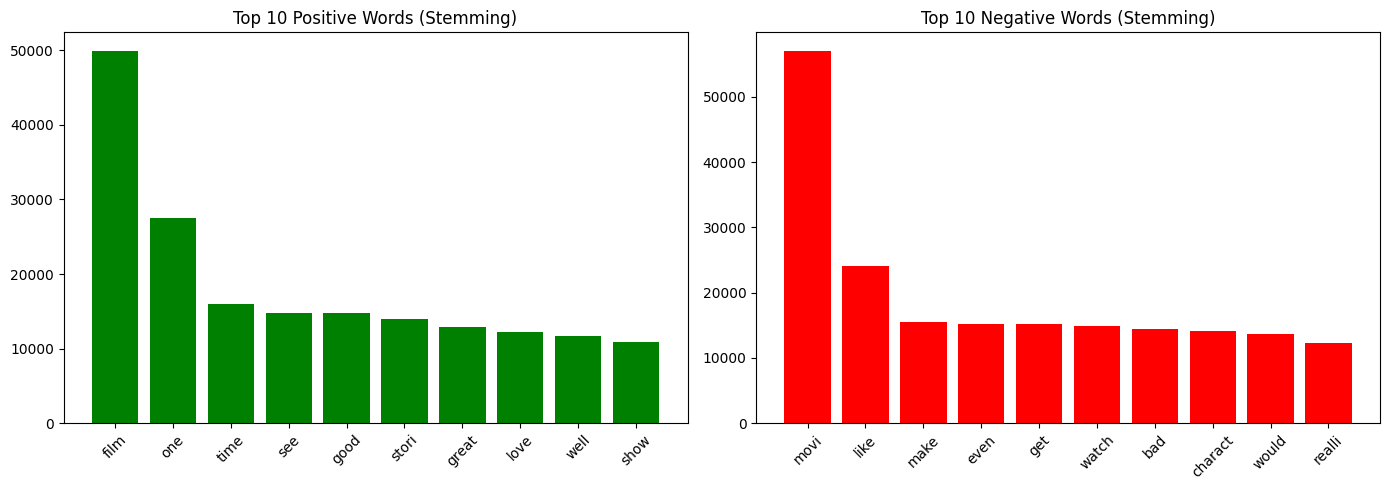

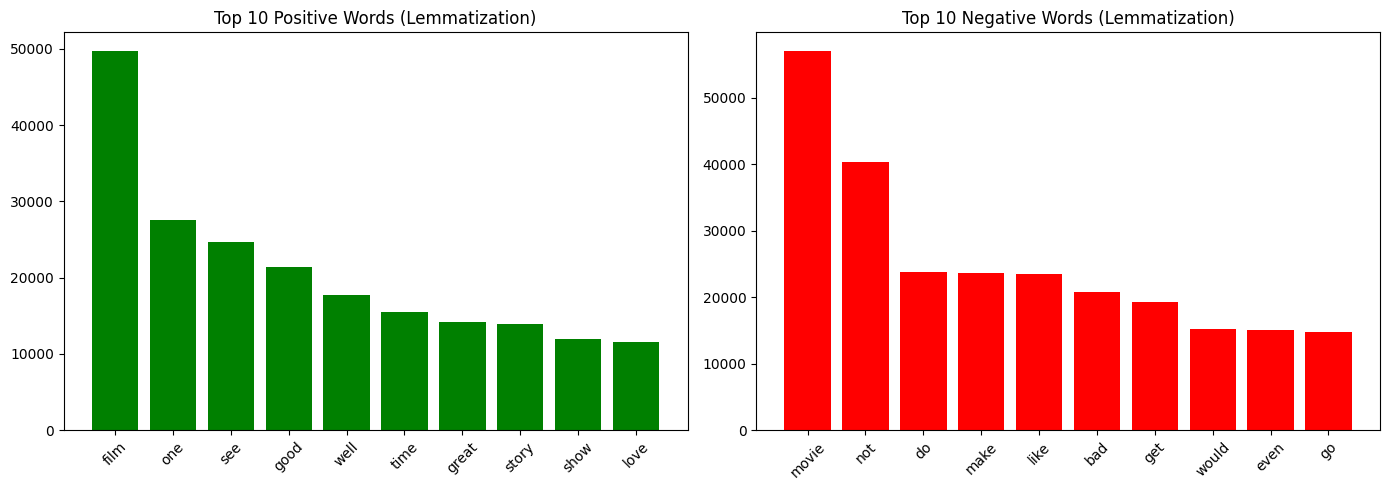

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
from ast import literal_eval

def top_words_by_sentiment(df, token_col, sentiment_col='sentiment', top_n=10):
    """
    Ambil top words positif & negatif dari kolom token
    tanpa duplikasi kata di kedua sisi.
    """
    # Ensure the token column is a list
    # Check if the column exists before processing
    if token_col not in df.columns:
        print(f"⚠️ Warning: Kolom '{token_col}' tidak tersedia.")
        return [], [] # Return empty lists if column doesn't exist

    # Convert string representation of list to actual list if needed
    if isinstance(df[token_col].iloc[0], str):
        df[token_col] = df[token_col].apply(
            lambda x: literal_eval(x) if isinstance(x, str) and x.startswith("[") else x
        )


    # Ambil token dari kelas positif & negatif
    pos_tokens = [tok for toks in df[df[sentiment_col] == 'positive'][token_col] for tok in toks if isinstance(toks, list)]
    neg_tokens = [tok for toks in df[df[sentiment_col] == 'negative'][token_col] for tok in toks if isinstance(toks, list)]

    # Hitung frekuensi
    pos_counter = Counter(pos_tokens)
    neg_counter = Counter(neg_tokens)

    # Hilangkan overlap kata
    overlap = set(pos_counter.keys()) & set(neg_counter.keys())
    for w in overlap:
        if pos_counter[w] >= neg_counter[w]:
            del neg_counter[w]  # lebih dominan positif → hapus dari negatif
        else:
            del pos_counter[w]  # lebih dominan negatif → hapus dari positif

    # Ambil top N
    top_pos = pos_counter.most_common(top_n)
    top_neg = neg_counter.most_common(top_n)

    return top_pos, top_neg


def plot_top_words(top_pos, top_neg, title):
    """
    Visualisasi bar chart untuk kata positif dan negatif.
    """
    if not top_pos and not top_neg:
        print(f"⚠️ Tidak ada data untuk divisualisasikan untuk {title}.")
        return

    fig, axes = plt.subplots(1, 2, figsize=(14,5))

    # Positif
    axes[0].bar([w for w, _ in top_pos], [f for _, f in top_pos], color="green")
    axes[0].set_title(f"Top {len(top_pos)} Positive Words ({title})")
    axes[0].tick_params(axis='x', rotation=45)

    # Negatif
    axes[1].bar([w for w, _ in top_neg], [f for _, f in top_neg], color="red")
    axes[1].set_title(f"Top {len(top_neg)} Negative Words ({title})")
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


# --- Analisis Tokenization ---
top_pos_tok, top_neg_tok = top_words_by_sentiment(final_df, 'tokens')
plot_top_words(top_pos_tok, top_neg_tok, "Tokenization")

# --- Analisis Stemming ---
top_pos_stem, top_neg_stem = top_words_by_sentiment(final_df, 'stemmed_tokens')
plot_top_words(top_pos_stem, top_neg_stem, "Stemming")

# --- Analisis Lemmatization ---
top_pos_lemma, top_neg_lemma = top_words_by_sentiment(final_df, 'lemmatized_tokens')
plot_top_words(top_pos_lemma, top_neg_lemma, "Lemmatization")

# Kesimpulan
Pipeline ini menghasilkan dataset yang sudah:
1. Bersih dan terstruktur.
2. Memiliki representasi kata dalam bentuk token, stem, dan lemma.
3. Dapat digunakan langsung untuk analisis sentimen atau pelatihan model machine learning.